In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.optimize as sop
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
mosprime3m = pd.read_csv('mosprime3m.csv',header=None,
                         index_col=0, names=['r3m'])['r3m'].sort_index()

mosprime3m_short = pd.read_csv('mosprime3m_short.csv', header=None,
                               index_col=0, names=['r3m'])['r3m'].sort_index()

mosprime3m_between = pd.read_csv('mosprime3m_between.csv', header=None,
                                 index_col=0, names=['r3m'])['r3m'].sort_index()

In [3]:
def CIR_path(r0, days, theta, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    a = a # альфа 
    theta = theta
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  a * (theta - r[t-1]) * dt + vol * rand[t] * np.sqrt(dt * r[t - 1])
    CIR = pd.DataFrame(r[:, 0], columns=['index'])
    CIR = CIR.values.flatten()
    return CIR


def CIR_p(data, opt, num_paths=10, alpha=0.7, title='Calibrated CIR Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(CIR_path(data[0], len(data), opt[0], opt[1],
                      opt[2]), lw=0.8, alpha=alpha)
    plt.title(title)
    plt.plot(data.values.flatten(), label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()
    


def CIR_ml_final_diff(p0, penalty=np.inf):
    theta, a, vol = p0
    if theta <= 0 or vol <= 0 or a <= 0 :
        return penalty 
    x = data
    dx = np.diff(data)
    dt = np.array([1/252]*len(dx))
    #dt = np.array([1]*len(dx))
    
    mu = a * (theta - x[:-1]) * dt 
    sigma = vol * np.sqrt(dt * x[:-1])
    
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [8]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def C0_ecdf_dist(f1, f2):
    xs1, ys1 = ecdf(f1)
    xs, ys = ecdf(f2)
    minv = np.minimum(xs1[0], xs[0]) - 0.001
    maxv = np.maximum(xs1[-1], xs[-1]) + 0.001

    xs = np.insert(xs, 0, minv)
    xs1 =  np.insert(xs1, 0 , minv)
    xs1 = np.insert(xs1, len(xs1), maxv)
    xs = np.insert(xs, len(xs), maxv)

    ys = np.insert(ys, 0, 0)
    ys = np.insert(ys, len(ys)-1, 1)
    ys1 = np.insert(ys1, 0, 0)
    ys1 = np.insert(ys1, len(ys)-1, 1)
    f = np.zeros(len(xs1))
    for i in range(len(xs1)):
        if xs[i] == xs1[i]:
            f[i] = np.abs(ys1[i]-ys[i])
        else: 
            temp = xs1[i] <xs
            f[i] = np.abs(ys1[i] - ys[temp.argmax()-1])
    return np.max(f)

def mean_C0(opt, n_path=100):
    t = []
    for i in range(n_path):
        t.append(C0_ecdf_dist(data, CIR_path(data[0], len(data), opt[0], opt[1], opt[2])))
    return np.mean(t)

def mean_max_dist(opt, data, num_paths):
    dist = []
    for i in range(num_paths):
        dist.append(np.max(np.abs(data - CIR_path(data[0], len(data), opt[0], opt[1], opt[2]))))
    return np.mean(dist)

 
def CIR_ml_lk(p0):
    theta, a, vol = p0
    X = data
    x = X
    dx = np.diff(X)
    dt = np.array([1/252]*len(dx))

    mu = a * (theta - x[:-1]) * dt 
    sigma = vol * np.sqrt(dt * x[:-1])

    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = (const + sum1 + sum2)
    return L

In [158]:
mosprime3m_short.index[0]

'2012-04-02'

In [13]:
data = mosprime3m_short

In [14]:
p3 = np.array([np.median(data),  max(data) - min(data) , np.sqrt(data.var())])

Optimization terminated successfully.
         Current function value: -205.183684
         Iterations: 20
         Function evaluations: 38
[8.46510156 0.73101524 0.20067571]
Среднее максимальное расстояние между траекториями:  0.5933081002832103
Среднее С0 расстояние между функциями распределения: 0.5485714285714286
Правдоподобие: 205.18368362436598


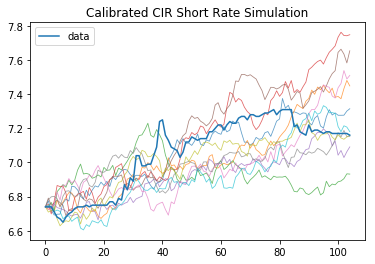

In [15]:
CIR_ml = sop.fmin(CIR_ml_final_diff, p3,
                        maxiter=100, maxfun=100, xtol=0.1, ftol=0.1)

print(CIR_ml)
print('Среднее максимальное расстояние между траекториями: ',mean_max_dist(CIR_ml, data, num_paths=10))
print('Среднее С0 расстояние между функциями распределения:' , mean_C0(CIR_ml, n_path=10))
print('Правдоподобие:' ,CIR_ml_lk(CIR_ml))
CIR_p(data, CIR_ml, num_paths=10)

In [16]:
len(data)

105

In [17]:
p1 = np.array([0.01, 0.01, 0.01])
p2 = np.array([0.1,  0.1, 0.1])
p4 = np.array([40, 2, 1])

In [62]:
def rolling_CIR(db=mosprime3m, periods=21):
    date_start_end = (pd.date_range(end = db.index.min(), periods=1, freq='d') + periods - 1).strftime('%Y-%m-%d')[0]
    #end_dates = pd.date_range(start=date_start_end, end = db.index.max(), freq='d').strftime('%Y-%m-%d')
    #end_dates = [i for i in end_dates if i in db.index]
    df_cal_CIR = pd.DataFrame(columns=["theta", "alpha", "vol", "mean", "median", "std"], index=np.array(db.index[periods:]))
    for i in tqdm(range(len(df_cal_CIR))):
        global data
        data = db.dropna().values[i:(periods+i)].flatten()
        x = data
        median = np.median(x)
        mean = np.mean(x)
        std = np.std(x)
        p4 = [median, np.max(x)-np.min(x), std]#db252_HW1.values[i,:3]
        par = sop.minimize(CIR_ml_final_diff, p4, method='Powell').x
        #par = sop.fmin(CIR_ml_final_diff, p3, disp=0,
        #      maxiter=10000, maxfun=10000, xtol=0.001, ftol=0.001)
        df_cal_CIR.iloc[i] = np.append(par, [mean, median, std])
    return df_cal_CIR

In [154]:
mosprime3m_short.std()

0.21248973256815584

In [150]:
data_gen = CIR_path(r0=6, days=100000, theta=6.4, a=0.7, vol=0.7)
data_gen = pd.DataFrame(data_gen, index=pd.date_range(start=1, periods=100000, freq='D'))

In [151]:
data = data_gen.values.flatten()
x = data
median = np.median(x)
mean = np.mean(x)
std = np.std(x)
p4 = [median, np.max(x)-np.min(x), std]#db252_HW1.values[i,:3]
p1 = np.array([0.01, 0.01, 0.01])
p2 = np.array([0.1,  0.1, 0.1])
p3 = np.array([40, 2, 1])
par = sop.minimize(CIR_ml_final_diff, p4, method='Powell').x

In [152]:
p4

[6.250555941726773, 10.471213088989012, 1.5013472027650545]

[6.35654084 0.6779188  0.69666299]
Среднее максимальное расстояние между траекториями:  8.228190702573789
Среднее С0 расстояние между функциями распределения: 0.034373999999999995


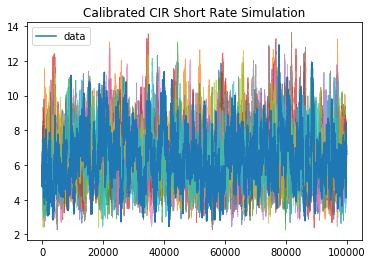

In [153]:
print(par)
print('Среднее максимальное расстояние между траекториями: ',mean_max_dist(par, data, num_paths=10))
print('Среднее С0 расстояние между функциями распределения:' , mean_C0(par, n_path=10))
CIR_p(data_gen[0], par, num_paths=10)

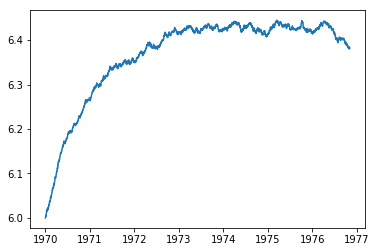

In [98]:
plt.plot(data_gen)
plt.show()

In [108]:
db252_CIR = rolling_CIR(db=data_gen, periods=252)

100%|██████████| 2248/2248 [00:12<00:00, 179.56it/s]


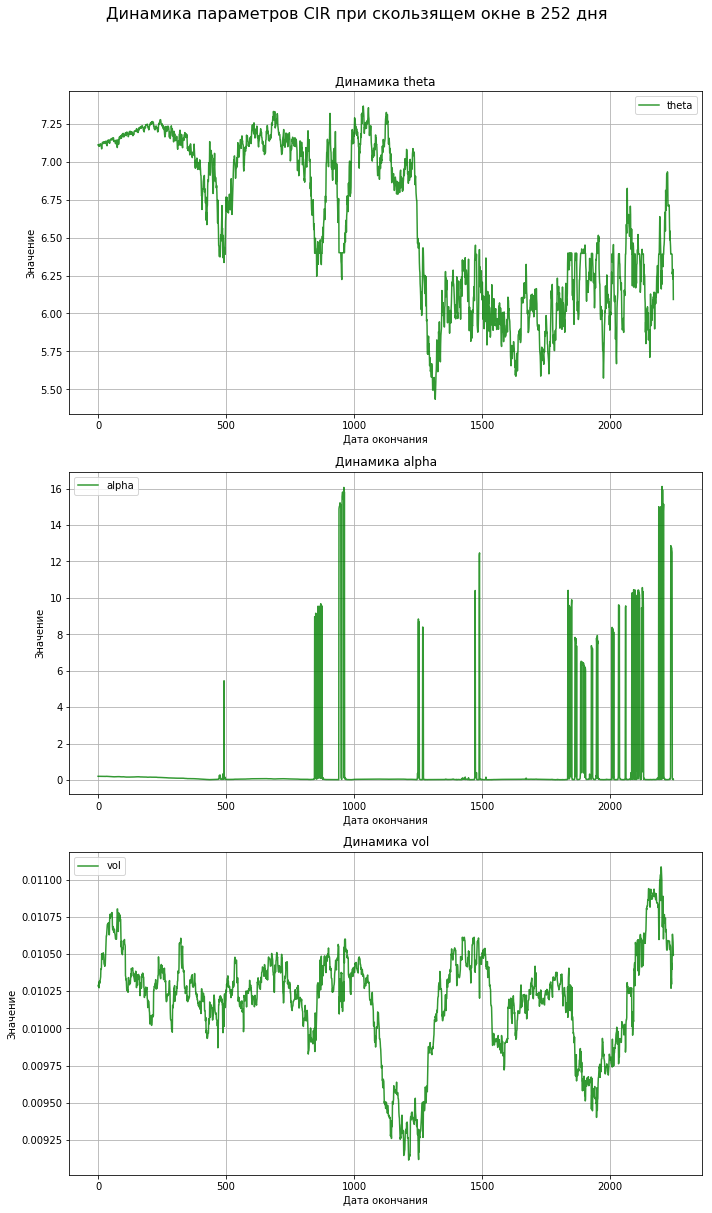

In [109]:
plt.figure(figsize=[10,16])
plt.subplot(3,1,1)
plt.plot(db252_CIR['theta'].values , 'g-',  alpha = 0.8, label = 'theta')
plt.title('Динамика theta')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
#plt.ylim([0,25])
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(db252_CIR['alpha'].values , 'g-',  alpha = 0.8, label = 'alpha')
plt.title('Динамика alpha')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(db252_CIR['vol'].values , 'g-',  alpha = 0.8, label = 'vol')
plt.title('Динамика vol')
plt.xlabel('Дата окончания') 
plt.ylabel('Значение')
#plt.ylim([0,10])
plt.legend()
plt.grid()


plt.suptitle('Динамика параметров CIR при скользящем окне в 252 дня' , y=1.05, fontsize=16)
plt.tight_layout()
plt.show()